In [1]:
import itertools
import os
import cv2
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,precision_score, recall_score, f1_score,accuracy_score, classification_report
from skimage import io, feature

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_confusion_matrix(confusion_matrix, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if classes is not None:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)

    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, f'{confusion_matrix[i, j]:.2f}', horizontalalignment='center', color='white' if confusion_matrix[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')


In [3]:
train_dir = 'WaferMap/balanced'
test_dir = 'WaferMap/test'

subdirs = os.listdir(train_dir)

In [5]:
# Function to load and display images from a specific subdirectory
def display_images_from_subdirectory(subdirectory):
    subdirectory_path = os.path.join(train_dir, subdirectory)
    image_files = os.listdir(subdirectory_path)

    fig, axes = plt.subplots(1, 3, figsize=(6, 2))
    for i in range(3):
        img_path = os.path.join(subdirectory_path, image_files[i])
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'{subdirectory} - {i + 1}')

    plt.show()

# Display example images for each subdirectory
#for subdir in subdirs:
    #display_images_from_subdirectory(subdir)


In [11]:
image_gen = ImageDataGenerator( rescale=1./255 )

train_images = image_gen.flow_from_directory(
    train_dir,
    target_size=(26, 26),
    batch_size=5,
    class_mode='categorical'
)

Found 2848 images belonging to 7 classes.


In [12]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_images = test_datagen.flow_from_directory(
    test_dir,
    target_size=(26, 26),
    batch_size=10,
    class_mode='categorical'
)

Found 661 images belonging to 7 classes.


In [13]:
batch_size = 16
img_shape=(26,26,3)

In [21]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', input_shape=(img_shape),
            activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax')) 

# learning rate
adam = Adam(learning_rate=0.0003)

model.compile(loss='categorical_crossentropy', optimizer=adam , metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 13, 13, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482,439 (1.84 MB)

 Trainable params: 482,439 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(
    train_images,
    epochs=15,
    validation_data=test_images
)

Epoch 1/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4330 - loss: 1.4176 - val_accuracy: 0.6233 - val_loss: 0.8302
Epoch 2/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8245 - loss: 0.4914 - val_accuracy: 0.6989 - val_loss: 0.8838
Epoch 3/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8732 - loss: 0.3421 - val_accuracy: 0.7141 - val_loss: 0.8075
Epoch 4/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9009 - loss: 0.2736 - val_accuracy: 0.7216 - val_loss: 0.7397
Epoch 5/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9022 - loss: 0.2586 - val_accuracy: 0.7262 - val_loss: 0.8295
Epoch 6/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9207 - loss: 0.2139 - val_accuracy: 0.7126 - val_loss: 0.7065
Epoch 7/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9312 - loss: 0.1948 - val_accuracy: 0.7443 - val_loss: 0.8869
Epoch 8/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9521 - loss: 0.1444 - val_accuracy: 0.

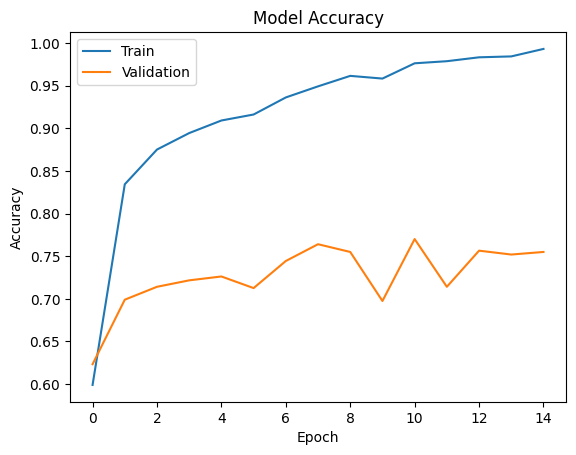

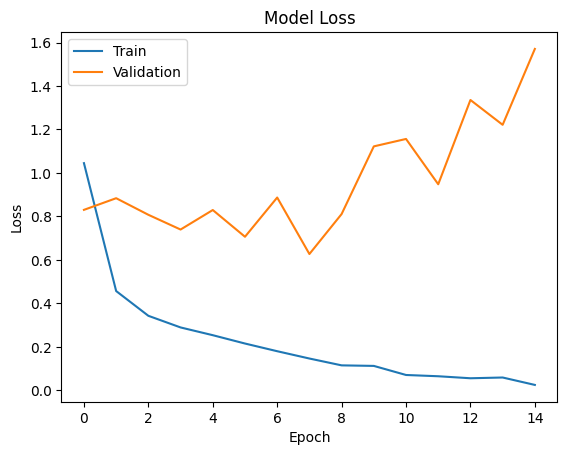

In [23]:
# get accuracy and loss plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


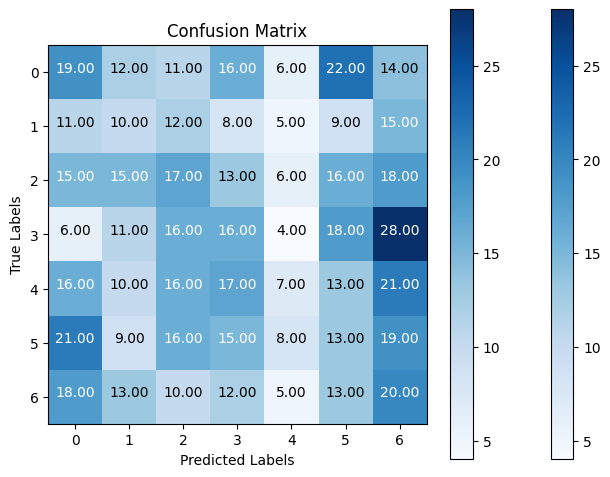

In [24]:
# Function to get the model predictions
def get_predictions(model, generator):
    num_steps = len(generator)
    return model.predict(generator, steps=num_steps, verbose=1)

# Get predictions for the validation set
validation_predictions = get_predictions(model, test_images)

# Convert predictions to class labels
predicted_labels = np.argmax(validation_predictions, axis=1)

# Convert true labels to class labels
true_labels = test_images.classes

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.imshow(confusion_matrix_result, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = [str(i) for i in range(test_images.num_classes)]

plot_confusion_matrix(confusion_matrix_result, classes)


In [25]:
precision_per_class = np.diag(confusion_matrix_result) / np.sum(confusion_matrix_result, axis=0)
recall_per_class = np.diag(confusion_matrix_result) / np.sum(confusion_matrix_result, axis=1)
f1_score_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

mean_precision = np.mean(precision_per_class)
mean_recall = np.mean(recall_per_class)
mean_f1_score = np.mean(f1_score_per_class)

# Print results
for class_idx, prec, rec, f1 in zip(range(len(precision_per_class)), precision_per_class, recall_per_class, f1_score_per_class):
    print(f'Class {class_idx}: Precision={prec:.2f}, Recall={rec:.2f}, F1-score={f1:.2f}')

print(f'\nAverages (Micro): Precision={mean_precision:.2f}, Recall={mean_recall:.2f}, F1-score={mean_f1_score:.2f}')
print(f'Accuracy: {accuracy_score(true_labels, predicted_labels):.2f}')

Class 0: Precision=0.18, Recall=0.19, F1-score=0.18
Class 1: Precision=0.12, Recall=0.14, F1-score=0.13
Class 2: Precision=0.17, Recall=0.17, F1-score=0.17
Class 3: Precision=0.16, Recall=0.16, F1-score=0.16
Class 4: Precision=0.17, Recall=0.07, F1-score=0.10
Class 5: Precision=0.12, Recall=0.13, F1-score=0.13
Class 6: Precision=0.15, Recall=0.22, F1-score=0.18

Averages (Micro): Precision=0.16, Recall=0.15, F1-score=0.15
Accuracy: 0.15


In [26]:
images = []
labels = []

for subdirectory in os.listdir(train_dir):
    if os.path.isdir(os.path.join(train_dir, subdirectory)):
        
        subdirectory_path = os.path.join(train_dir, subdirectory)
        
        for image_name in os.listdir(subdirectory_path):

            image_path = os.path.join(subdirectory_path, image_name)
            
            image = io.imread(image_path)
            
            # Resize the image if it is too small // bugfix
            if image.shape[0] < 24 or image.shape[1] < 24:
                image = cv2.resize(image, (24, 24))
            
            # Apply HOG to extract features
            hog_features, _ = feature.hog(image, visualize=True, channel_axis=-1)
            # Histogram of Oriented Gradients (HOG) is a feature descriptor used for object detection. 
            # It works by counting occurrences of gradient orientation in localized portions of an image,
            # providing robust edge and shape information.

            images.append(hog_features)
            labels.append(subdirectory)

# Ensure all HOG feature vectors have the same length // bugfix
max_length = max(len(f) for f in images)
images = [np.pad(f, (0, max_length - len(f)), 'constant') if len(f) < max_length else f[:max_length] for f in images]

X = np.array(images)
y = np.array(labels)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM model
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Make predictions on the test set
svm_predictions = svm_model.predict(X_test)


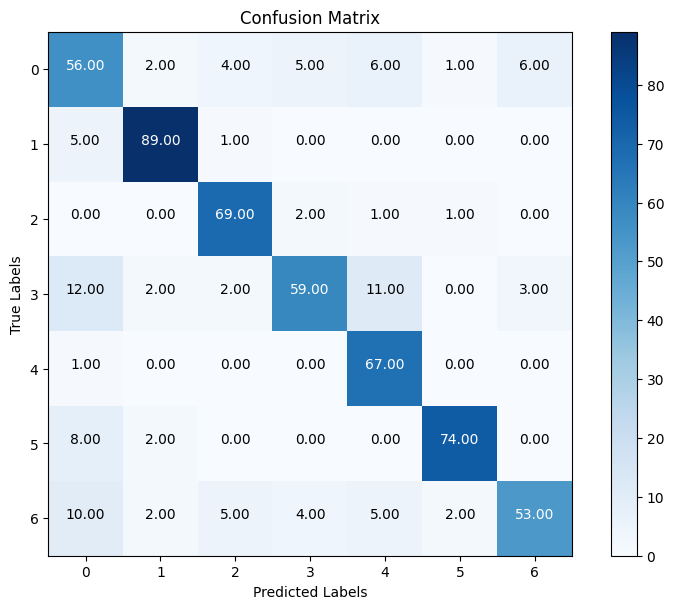

In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix_svm = confusion_matrix(y_test, svm_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(confusion_matrix_svm, classes)
plt.show()

In [28]:
# Evaluate the performance of the SVM model
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_classification_report = classification_report(y_test, svm_predictions)

print(f'SVM Accuracy: {svm_accuracy:.2f}')
print('SVM Classification Report:')
print(svm_classification_report)

SVM Accuracy: 0.82
SVM Classification Report:
              precision    recall  f1-score   support

      Center       0.61      0.70      0.65        80
       Donut       0.92      0.94      0.93        95
   Edge-ring       0.85      0.95      0.90        73
         Loc       0.84      0.66      0.74        89
        None       0.74      0.99      0.85        68
      Random       0.95      0.88      0.91        84
     Scratch       0.85      0.65      0.74        81

    accuracy                           0.82       570
   macro avg       0.82      0.82      0.82       570
weighted avg       0.83      0.82      0.82       570



In [29]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

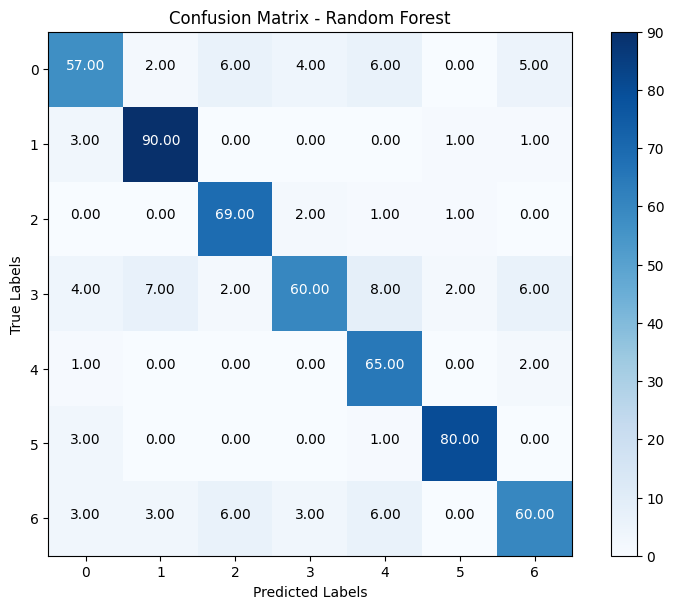

In [30]:
# Plot the Random Forest confusion matrix
confusion_matrix_rf = confusion_matrix(y_test, rf_predictions)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(confusion_matrix_rf, classes)
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [31]:
# Evaluate the performance of the Random Forest model
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_classification_report = classification_report(y_test, rf_predictions)

print(f'Random Forest Accuracy: {rf_accuracy:.2f}')
print('Random Forest Classification Report:')
print(rf_classification_report)

Random Forest Accuracy: 0.84
Random Forest Classification Report:
              precision    recall  f1-score   support

      Center       0.80      0.71      0.75        80
       Donut       0.88      0.95      0.91        95
   Edge-ring       0.83      0.95      0.88        73
         Loc       0.87      0.67      0.76        89
        None       0.75      0.96      0.84        68
      Random       0.95      0.95      0.95        84
     Scratch       0.81      0.74      0.77        81

    accuracy                           0.84       570
   macro avg       0.84      0.85      0.84       570
weighted avg       0.85      0.84      0.84       570



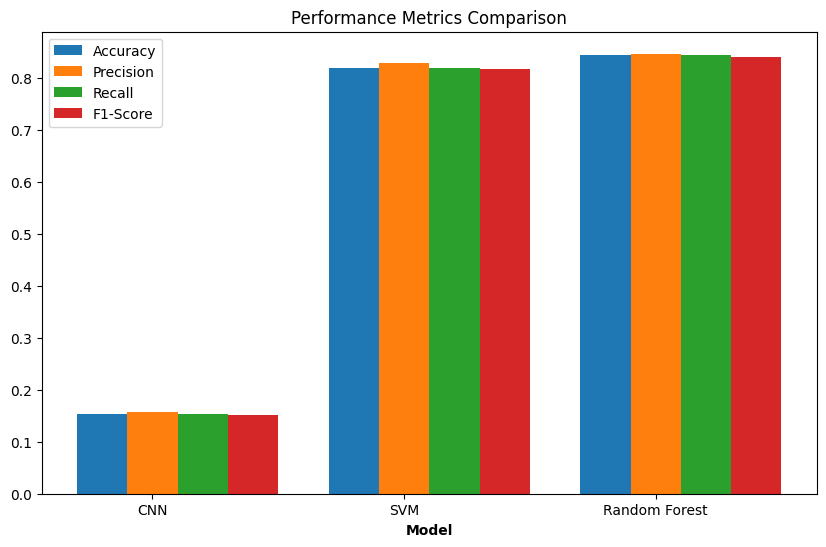

In [32]:
# Evaluate the performance of the CNN model
cnn_accuracy = accuracy_score(true_labels, predicted_labels)
cnn_precision = precision_score(true_labels, predicted_labels, average='weighted')
cnn_recall = recall_score(true_labels, predicted_labels, average='weighted')
cnn_f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Evaluate the performance of the SVM model
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions, average='weighted')
svm_recall = recall_score(y_test, svm_predictions, average='weighted')
svm_f1 = f1_score(y_test, svm_predictions, average='weighted')

# Evaluate the performance of the Random Forest model
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions, average='weighted')
rf_recall = recall_score(y_test, rf_predictions, average='weighted')
rf_f1 = f1_score(y_test, rf_predictions, average='weighted')

# Prepare data for plotting
models = ['CNN', 'SVM', 'Random Forest']
accuracies = [cnn_accuracy, svm_accuracy, rf_accuracy]
precisions = [cnn_precision, svm_precision, rf_precision]
recalls = [cnn_recall, svm_recall, rf_recall]
f1_scores = [cnn_f1, svm_f1, rf_f1]

barWidth = 0.2
r1 = np.arange(len(accuracies))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(10, 6))

plt.bar(r1, accuracies, width=barWidth, label='Accuracy')
plt.bar(r2, precisions, width=barWidth, label='Precision')
plt.bar(r3, recalls, width=barWidth, label='Recall')
plt.bar(r4, f1_scores, width=barWidth, label='F1-Score')

plt.xlabel('Model', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(accuracies))], models)
plt.title('Performance Metrics Comparison')
plt.legend()

plt.show()

I have reduced and changed the datas in conflicting classes, reduced model complexity, downscaled the target size, overall achieved better results but still, the CNN predicts poorly on test data. Other than that, I extracted histogram features directly from data instead of the C-model, but that's not our topic atm.